In [236]:
import os
import cv2 as cv
import numpy as np

from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split

In [237]:
IMAGES_PATH = Path('Kvasir-SEG') / 'images'
MASKS_PATH = Path('Kvasir-SEG') / 'masks'

In [238]:
images_files = os.listdir(IMAGES_PATH)
masks_files = os.listdir(MASKS_PATH)

In [243]:
def show_imgs(imgs):
    fig, axs = plt.subplots(1, len(imgs), figsize=(10, 5))

    if len(imgs) == 1:
        axs = [axs]

    [axs[i].imshow(cv.cvtColor(imgs[i], cv.COLOR_BGR2RGB)) for i in range(len(imgs))]

    plt.tight_layout()

    plt.show()

In [240]:
SIZE = 200


def read_img_and_mask(index):
    img = cv.imread(str(IMAGES_PATH / images_files[index]))
    resized_img = cv.resize(img, (SIZE, SIZE))
    msk = cv.imread(str(MASKS_PATH / masks_files[index]), 0)
    resized_msk = cv.resize(msk, (SIZE, SIZE))

    return resized_img, resized_msk

In [241]:
def combine_img_width_msk(img, msk, color=[255, 0, 0]):
    edge = cv.Canny(msk, 30, 100)
    combined_img = img.copy()
    combined_img[edge == 255] = color
    return combined_img

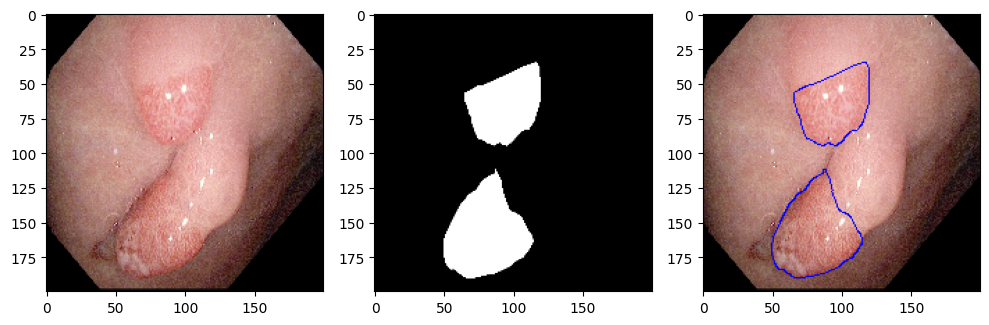

In [246]:
img, msk = read_img_and_mask(7)
marked_img = combine_img_width_msk(img, msk)
show_imgs([img, msk, marked_img])

In [260]:
X_train, X_test, y_train, y_test = train_test_split(
    images_files, masks_files, test_size=0.1, random_state=1
)

print(
    " X_train:",
    len(X_train),
    " y_train:",
    len(y_train),
    " X_test:",
    len(X_test),
    " y_test:",
    len(y_test),
)

 X_train: 900  y_train: 900  X_test: 100  y_test: 100
